<b><h1 style="font-size:28px;">Facial emotions detection with PyTorch</h1></b>

<h4>Context</h4>

<p style="font-size:16px;">Emotions detection has been something  which seemed unachievable for some time, but with provision of powerful computer power, this confirms that emotion detection can now be  implemented in many areas requiring additional security or information about the person.</p>

<h4>Rationale</h4>

<p style="font-size:16px;">This notebook confirms that through pytorch we can actually get the emotions  through just taking the picture of a person.</p>

<h4>Aims and objectives</h4>
<p style="font-size:16px;">
The aim of this project is to determine whether a person is Angry, Disgusted, scared, Happy,Sad,Surprise or Neutral based on the input data to the model.</p>

In [1]:
import pandas as pd
data = pd.read_csv('../dataset/fer2013.csv')
data.head(2)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training


The data used, fer2013.csv was extracted from one the face dtection challenges from kaggle.
Description of the dataset.
<ul>
<li><h4>dataset properties</h4></li>
<li>This dataset consists of 48x48 pixel grayscale images of faces</li>
    <li>Breakdown of the dataset properties</li>
<li>0: -4593 images- Angry</li>
<li>1: -547 images- Disgust</li>
<li>2: -5121 images- Fear</li>
<li>3: -8989 images- Happy</li>
<li>4: -6077 images- Sad</li>
<li>5: -4002 images- Surprise</li>
<li>6: -6198 images- Neutral</li>
    
</ul>

In [7]:
import torch.nn as nn


class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels,
                                   bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class ResidualBlock(nn.Module):

    def __init__(self, in_channeld, out_channels):
        super(ResidualBlock, self).__init__()

        self.residual_conv = nn.Conv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=1, stride=2,
                                       bias=False)
        self.residual_bn = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)

        self.sepConv1 = SeparableConv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.relu = nn.ReLU()

        self.sepConv2 = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        res = self.residual_conv(x)
        res = self.residual_bn(res)
        x = self.sepConv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.sepConv2(x)
        x = self.bn2(x)
        x = self.maxp(x)
        return res + x


class Model(nn.Module):

    def __init__(self, num_classes):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8, affine=True, momentum=0.99, eps=1e-3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(8, momentum=0.99, eps=1e-3)
        self.relu2 = nn.ReLU()

        self.module1 = ResidualBlock(in_channeld=8, out_channels=16)
        self.module2 = ResidualBlock(in_channeld=16, out_channels=32)
        self.module3 = ResidualBlock(in_channeld=32, out_channels=64)
        self.module4 = ResidualBlock(in_channeld=64, out_channels=128)

        self.last_conv = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=3, padding=1)
        self.avgp = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)
        x = self.last_conv(x)
        x = self.avgp(x)
        x = x.view((x.shape[0], -1))
        return x


<b>1.ResidualBlock:</b>

<i>To create a clean code is mandatory to think about the main building blocks of the application, 
    or of the network in our case. The residual block takes an input with in_channels, applies some blocks of convolutional layers to reduce it to out_channels and sum it up to the original input. If their sizes mismatch, then 
    the input goes into an identity. We can abstract this process and create an interface that can be extended.</i><br>
    
<b>2.Separableconv2d.</b>
    
    
<i>Separable convolutions consist of first performing a depthwise spatial convolution (which acts on each input channel separately) followed by a pointwise convolution which mixes the resulting output channels. The groupd argument controls how many output channels are generated per input channel in the depthwise step.</i><br>
    
<b>3.class Model(nn.model):</b>
    
This is the base class for all neural network modules in pytroch.<br>

<b>4. def forward()</b><br>
<i>
This is a pyrtorch hook. The hook can be a forward hook or a backward hook. The forward hook will be executed when a forward call is executed. The backward hook will be executed in the backward phase.</i>



In [58]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import csv
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

if not torch.cuda.is_available():
    from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

shape = (44, 44)


class DataSetFactory:

    def __init__(self):
        images = []
        emotions = []
        private_images = []
        private_emotions = []
        public_images = []
        public_emotions = []

        with open('fer2013.csv', 'r') as csvin:
            data = csv.reader(csvin)
            next(data)
            for row in data:
                face = [int(pixel) for pixel in row[1].split()]
                face = np.asarray(face).reshape(48, 48)
                face = face.astype('uint8')

                if row[-1] == 'Training':
                    emotions.append(int(row[0]))
                    images.append(Image.fromarray(face))
                elif row[-1] == "PrivateTest":
                    private_emotions.append(int(row[0]))
                    private_images.append(Image.fromarray(face))
                elif row[-1] == "PublicTest":
                    public_emotions.append(int(row[0]))
                    public_images.append(Image.fromarray(face))

        print('training size %d : private val size %d : public val size %d' % (
            len(images), len(private_images), len(public_images)))
        train_transform = transforms.Compose([
            transforms.RandomCrop(shape[0]),
            transforms.RandomHorizontalFlip(),
            ToTensor(),
        ])
        val_transform = transforms.Compose([
            transforms.CenterCrop(shape[0]),
            ToTensor(),
        ])

        self.training = DataSet(transform=train_transform, images=images, emotions=emotions)
        self.private = DataSet(transform=val_transform, images=private_images, emotions=private_emotions)
        self.public = DataSet(transform=val_transform, images=public_images, emotions=public_emotions)


class DataSet(torch.utils.data.Dataset):

    def __init__(self, transform=None, images=None, emotions=None):
        self.transform = transform
        self.images = images
        self.emotions = emotions

    def __getitem__(self, index):
        image = self.images[index]
        emotion = self.emotions[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, emotion

    def __len__(self):
        return len(self.images)


def main():
    # variables  -------------
    batch_size = 128
    lr = 0.01
    epochs = 350
    learning_rate_decay_start = 80
    learning_rate_decay_every = 5
    learning_rate_decay_rate = 0.9
    # ------------------------

    classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    network = Model(num_classes=len(classes)).to(device)
    if not torch.cuda.is_available():
        summary(network, (1, shape[0], shape[1]))

    optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9, weight_decay=5e-3)
    criterion = nn.CrossEntropyLoss()
    factory = DataSetFactory()

    training_loader = DataLoader(factory.training, batch_size=batch_size, shuffle=True, num_workers=1)
    validation_loader = {
        'private': DataLoader(factory.private, batch_size=batch_size, shuffle=True, num_workers=1),
        'public': DataLoader(factory.public, batch_size=batch_size, shuffle=True, num_workers=1)
    }

    min_validation_loss = {
        'private': 10000,
        'public': 10000,
    }

    for epoch in range(epochs):
        network.train()
        total = 0
        correct = 0
        total_train_loss = 0
        if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:

            #
            frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
            decay_factor = learning_rate_decay_rate ** frac
            current_lr = lr * decay_factor
            for group in optimizer.param_groups:
                group['lr'] = current_lr
        else:
            current_lr = lr

        print('learning_rate: %s' % str(current_lr))
        for i, (x_train, y_train) in enumerate(training_loader):
            optimizer.zero_grad()
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_predicted = network(x_train)
            loss = criterion(y_predicted, y_train)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(y_predicted.data, 1)
            total_train_loss += loss.data
            total += y_train.size(0)
            correct += predicted.eq(y_train.data).sum()
        accuracy = 100. * float(correct) / total
        print('Epoch [%d/%d] Training Loss: %.4f, Accuracy: %.4f' % (
            epoch + 1, epochs, total_train_loss / (i + 1), accuracy))

        network.eval()
        with torch.no_grad():
            for name in ['private', 'public']:
                total = 0
                correct = 0
                total_validation_loss = 0
                for j, (x_val, y_val) in enumerate(validation_loader[name]):
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    y_val_predicted = network(x_val)
                    val_loss = criterion(y_val_predicted, y_val)
                    _, predicted = torch.max(y_val_predicted.data, 1)
                    total_validation_loss += val_loss.data
                    total += y_val.size(0)
                    correct += predicted.eq(y_val.data).sum()

                accuracy = 100. * float(correct) / total
                if total_validation_loss <= min_validation_loss[name]:
                    if epoch >= 10:
                        print('saving new model')
                        state = {'net': network.state_dict()}
                        torch.save(state, '%s_model_%d_%d.t7' % (name, epoch + 1, accuracy))
                    min_validation_loss[name] = total_validation_loss

                print('Epoch [%d/%d] %s validation Loss: %.4f, Accuracy: %.4f' % (
                    epoch + 1, epochs, name, total_validation_loss / (j + 1), accuracy))


if __name__ == "__main__":
    main()


training size 28709 : private val size 3589 : public val size 3589
learning_rate: 0.01
Epoch [1/350] Training Loss: 1.6956, Accuracy: 32.5961
Epoch [1/350] private validation Loss: 1.6354, Accuracy: 38.2279
Epoch [1/350] public validation Loss: 1.6702, Accuracy: 37.2249
learning_rate: 0.01
Epoch [2/350] Training Loss: 1.4513, Accuracy: 44.0907
Epoch [2/350] private validation Loss: 1.3704, Accuracy: 48.2028
Epoch [2/350] public validation Loss: 1.4136, Accuracy: 46.7540
learning_rate: 0.01
Epoch [3/350] Training Loss: 1.3463, Accuracy: 48.3368
Epoch [3/350] private validation Loss: 1.3108, Accuracy: 50.9613
Epoch [3/350] public validation Loss: 1.3278, Accuracy: 50.0139
learning_rate: 0.01
Epoch [4/350] Training Loss: 1.2753, Accuracy: 51.3637
Epoch [4/350] private validation Loss: 1.2328, Accuracy: 51.3235
Epoch [4/350] public validation Loss: 1.2734, Accuracy: 51.7693
learning_rate: 0.01
Epoch [5/350] Training Loss: 1.2343, Accuracy: 52.6351
Epoch [5/350] private validation Loss: 1.2

This section describes the Model and the output, this was trained on corei5 2.3ghz intel processor.
<b>About the model</b><br>



This model will process in batches of 128 items per epoch <a href="https://radiopaedia.org/articles/epoch-machine-learning#:~:text=An%20epoch%20is%20a%20term,of%20data%20is%20very%20large">(you can find definition of these terms here)</a>

The learning rate will start at 0.1 but it will be optimized with SGD optimizer to make the model optimize better and also Crossenthropyloss function is also chosen for this particular task.
The images are also fliped horizontally and cropped periodically and randomly and also converted to tensor.

The output of the model will give out the training loss, accuracy based on the overall performance and also based on the fer2013.csv data. 

In [ ]:


from collections import OrderedDict

import torch
import torch.nn as nn
from torch.nn import functional as F

class _BaseWrapper(object):
  

    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
       
        self.model.zero_grad()
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)

    def backward(self, ids):
      

        one_hot = self._encode_one_hot(ids)
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
       
        for handle in self.handlers:
            handle.remove()


class BackPropagation(_BaseWrapper):
    def forward(self, image):
        self.image = image.requires_grad_()
        return super(BackPropagation, self).forward(self.image)

    def generate(self):
        gradient = self.image.grad.clone()
        self.image.grad.zero_()
        return gradient


class GuidedBackPropagation(BackPropagation):
  

    def __init__(self, model):
        super(GuidedBackPropagation, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
           
            if isinstance(module, nn.ReLU):
                return (torch.clamp(grad_in[0], min=0.0),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class GradCAM(_BaseWrapper):
   

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = OrderedDict()
        self.grad_pool = OrderedDict()
        self.candidate_layers = candidate_layers  # list

        def forward_hook(key):
            def forward_hook_(module, input, output):
                # Save feature maps
                self.fmap_pool[key] = output.detach()

            return forward_hook_

        def backward_hook(key):
            def backward_hook_(module, grad_in, grad_out):
                # Save the gradients correspond to the featuremaps
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook_

        
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(forward_hook(name)))
                self.handlers.append(module.register_backward_hook(backward_hook(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def _compute_grad_weights(self, grads):
        return F.adaptive_avg_pool2d(grads, 1)

    def forward(self, image):
        self.image_shape = image.shape[2:]
        return super(GradCAM, self).forward(image)

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = self._compute_grad_weights(grads)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)

        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam




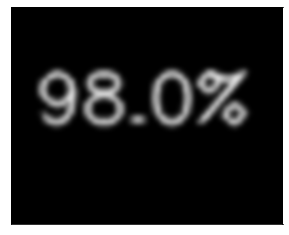

In [13]:
import os.path as osp

import cv2
import matplotlib.cm as cm
import numpy as np
import torch.hub
import os
import model
from PIL import Image
from torchvision import transforms
from torchsummary import summary
from visualize.grad_cam import BackPropagation, GradCAM,GuidedBackPropagation

faceCascade = cv2.CascadeClassifier('./visualize/haarcascade_frontalface_default.xml')
shape = (48,48)
classes = [
    'Angry',
    'Disgust',
    'Fear',
    'Happy',
    'Sad',
    'Surprised',
    'Neutral'
]

def preprocess(image_path):
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])
    image = cv2.imread(image_path)
    faces = faceCascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(1, 1),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    if len(faces) == 0:
        print('no face found')
        face = cv2.resize(image, shape)
    else:
        (x, y, w, h) = faces[0]
        face = image[y:y + h, x:x + w]
        face = cv2.resize(face, shape)

    img = Image.fromarray(face).convert('L')
    inputs = transform_test(img)
    return inputs, face


def get_gradient_image(gradient):
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    return np.uint8(gradient)


def get_gradcam_image(gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    return np.uint8(gcam)


def guided_backprop(images, model_name):

    for i, image in enumerate(images):
        target, raw_image = preprocess(image['path'])
        image['image'] = target
        image['raw_image'] = raw_image

    net = model.Model(num_classes=len(classes))
    checkpoint = torch.load(os.path.join('../trained', model_name), map_location=torch.device('cpu'))
    net.load_state_dict(checkpoint['net'])
    net.eval()
    #summary(net, (1, shape[0], shape[1]))

    result_images = []
    for index, image in enumerate(images):
        img = torch.stack([image['image']])
        bp = BackPropagation(model=net)
        probs, ids = bp.forward(img)
        gcam = GradCAM(model=net)
        _ = gcam.forward(img)

        gbp = GuidedBackPropagation(model=net)
        _ = gbp.forward(img)

        # Guided Backpropagation
        actual_emotion = ids[:,0]
        gbp.backward(ids=actual_emotion.reshape(1,1))
        gradients = gbp.generate()

        # Grad-CAM
        gcam.backward(ids=actual_emotion.reshape(1,1))
        regions = gcam.generate(target_layer='last_conv')

        # Get Images
        label_image = np.zeros((shape[0],65, 3), np.uint8)
        cv2.putText(label_image, classes[actual_emotion.data], (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

        prob_image = np.zeros((shape[0],60,3), np.uint8)
        cv2.putText(prob_image, '%.1f%%' % (probs.data[:,0] * 100), (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        guided_bpg_image = get_gradient_image(gradients[0])
        guided_bpg_image = cv2.merge((guided_bpg_image, guided_bpg_image, guided_bpg_image))

        grad_cam_image = get_gradcam_image(gcam=regions[0, 0],raw_image=image['raw_image'])

        guided_gradcam_image = get_gradient_image(torch.mul(regions, gradients)[0])
        guided_gradcam_image = cv2.merge((guided_gradcam_image, guided_gradcam_image, guided_gradcam_image))

        img = cv2.hconcat([image['raw_image'],label_image,prob_image,guided_bpg_image,grad_cam_image,guided_gradcam_image])
        result_images.append(img)
        #print(image['path'],classes[actual_emotion.data], probs.data[:,0] * 100)
        from matplotlib import pyplot as plt
        plt.imshow(prob_image, cmap = 'gray', interpolation = 'bicubic')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.show()
    #cv2.imwrite('../test/guided_gradcam.jpg',cv2.resize(cv2.vconcat(result_images), None, fx=2,fy=2))


def main():
    guided_backprop(
        images=[
            #{'path': '../test/angry.jpg'},
            #{'path': '../test/happy.jpg'},
            #{'path': '../test/sad.jpg'},
            {'path': '../test/surprised.jpg'},
        ],
        model_name='private_model_233_66.t7'
    )


if __name__ == "__main__":
    main()


This Code cell is responsible for feature extraction from an input image, and its provides the bright parts of the image.

In essence,  GuidedBackPropagation, neurons that have no effects or negative effects on the prediction value of a target class are masked out and ignored. By doing so, we can prevent the flow of gradients through such neurons, resulting in less noise.

<b>Test</b><br>





This code cell is the test case based on the images provided in the test folder, the four images are fed into the model,and the result saved as generated.jpg into the test folder.

We load our model here,  model_name='private_model_233_66.t7' this is the output of the trained model based on the best accuracy and performance. When we train the model its always saving in this file format, there are several files in the the trained folder, this was chosen because at this instance, the model was at its best accuracy based on the model output.

Its then loaded and  the four images are passed through the extracted features of the model, and the result is stored into the /test folder as generated.jpg

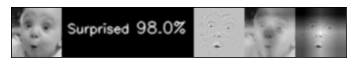

In [5]:
img = cv2.imread('../test/guided_gradcam.jpg',0)
from matplotlib import pyplot as plt
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

The generated image is now ploted to be easily accessible through cv2 and matplotlib libries

<b>Performance</b>

As from the plotted image above, the model had 99.7% accuracy on the angry inputs,93.8% accuracy on the happy inputs,91.3% accuracy on the sad inputs,98.0% accuracy on the surprised inputs.

From the given aims and objectives, the model performed as expected.


The code can be used for different functionalitie which need more user information to be detected automatically just from the facial picture or expression.

In [9]:
import os  
import cv2  
import numpy as np  




  
#load model  
model='private_model_233_66.t7' 
#load weights  

  
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')  
  
cap=cv2.VideoCapture(0)  
  
while True:  
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image  
    if not ret:  
        continue  
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)  
  
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)  
  
  
    for (x,y,w,h) in faces_detected:  
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)  
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image  
        roi_gray=cv2.resize(roi_gray,(48,48))  
        img_pixels = image.img_to_array(roi_gray)  
        img_pixels = np.expand_dims(img_pixels, axis = 0)  
        img_pixels /= 255  
  
        import os.path as osp

        import cv2
        import matplotlib.cm as cm
        import numpy as np
        import torch.hub
        import os
        import model
        from PIL import Image
        from torchvision import transforms
        from torchsummary import summary
        from visualize.grad_cam import BackPropagation, GradCAM,GuidedBackPropagation

        faceCascade = cv2.CascadeClassifier('./visualize/haarcascade_frontalface_default.xml')
        shape = (48,48)
        classes = [
       'Angry',
       'Disgust',
       'Fear',
       'Happy',
       'Sad',
       'Surprised',
       'Neutral'
        ]

        def preprocess(image_path):
            transform_test = transforms.Compose([
            transforms.ToTensor()
        ])
        image = cv2.imread(image_path)
        faces = faceCascade.detectMultiScale(
            image,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(1, 1),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

        if len(faces) == 0:
            print('no face found')
            face = cv2.resize(image, shape)
        else:
            (x, y, w, h) = faces[0]
            face = image[y:y + h, x:x + w]
            face = cv2.resize(face, shape)

        img = Image.fromarray(face).convert('L')
        inputs = transform_test(img)
    #return inputs, face


    def get_gradient_image(gradient):
        gradient = gradient.cpu().numpy().transpose(1, 2, 0)
        gradient -= gradient.min()
        gradient /= gradient.max()
        gradient *= 255.0
        return np.uint8(gradient)


    def get_gradcam_image(gcam, raw_image, paper_cmap=False):
        gcam = gcam.cpu().numpy()
        cmap = cm.jet_r(gcam)[..., :3] * 255.0
        if paper_cmap:
            alpha = gcam[..., None]
            gcam = alpha * cmap + (1 - alpha) * raw_image
        else:
            gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
            return np.uint8(gcam)


    def guided_backprop(cap, model_name):

        for i, image in enumerate(images):
            target, raw_image = preprocess(image['path'])
            image['image'] = target
            image['raw_image'] = raw_image

        net = model.Model(num_classes=len(classes))
        checkpoint = torch.load(os.path.join('../trained', model_name), map_location=torch.device('cpu'))
        net.load_state_dict(checkpoint['net'])
        net.eval()
    #summary(net, (1, shape[0], shape[1]))

        result_images = []
        for index, image in enumerate(images):
            img = torch.stack([image['image']])
            bp = BackPropagation(model=net)
            probs, ids = bp.forward(img)
            gcam = GradCAM(model=net)
            _ = gcam.forward(img)

            gbp = GuidedBackPropagation(model=net)
            _ = gbp.forward(img)

        # Guided Backpropagation
            actual_emotion = ids[:,0]
            gbp.backward(ids=actual_emotion.reshape(1,1))
            gradients = gbp.generate()

        # Grad-CAM
            gcam.backward(ids=actual_emotion.reshape(1,1))
            regions = gcam.generate(target_layer='last_conv')

        # Get Images
            label_image = np.zeros((shape[0],65, 3), np.uint8)
            cv2.putText(label_image, classes[actual_emotion.data], (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

            prob_image = np.zeros((shape[0],60,3), np.uint8)
            cv2.putText(prob_image, '%.1f%%' % (probs.data[:,0] * 100), (5, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

            guided_bpg_image = get_gradient_image(gradients[0])
            guided_bpg_image = cv2.merge((guided_bpg_image, guided_bpg_image, guided_bpg_image))

            grad_cam_image = get_gradcam_image(gcam=regions[0, 0],raw_image=image['raw_image'])

            guided_gradcam_image = get_gradient_image(torch.mul(regions, gradients)[0])
            guided_gradcam_image = cv2.merge((guided_gradcam_image, guided_gradcam_image, guided_gradcam_image))

            img = cv2.hconcat([image['raw_image'],label_image,prob_image,guided_bpg_image,grad_cam_image,guided_gradcam_image])
            result_images.append(img)
         #print(image['path'],classes[actual_emotion.data], probs.data[:,0] * 100)
            from matplotlib import pyplot as plt
            plt.imshow(prob_image, cmap = 'gray', interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            plt.show()
    #cv2.imwrite('../test/guided_gradcam.jpg',cv2.resize(cv2.vconcat(result_images), None, fx=2,fy=2))


    def main():
        guided_backprop(
            images=[
                #{'path': '../test/angry.jpg'},
                #{'path': '../test/happy.jpg'},
                #{'path': '../test/sad.jpg'},
                {'path': '../test/surprised.jpg'},
            ],
            model_name='private_model_233_66.t7'
       )



  
  
        #find max indexed array  
        #max_index = np.argmax(predictions[0])  
  
        #emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')  
        #predicted_emotion = emotions[max_index]  
  
        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)  
  
    resized_img = cv2.resize(test_img, (1000, 700))  
    cv2.imshow('Facial emotion analysis ',resized_img)  
  
  
  
    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed  
        break  
cap.release()  
cv2.destroyAllWindows  

if __name__ == "__main__":
    main()

KeyboardInterrupt: 

In [ ]:
import os  
import cv2  
import numpy as np  




  
#load model  
model='private_model_233_66.t7' 
#load weights  

  
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')  
  
cap=cv2.VideoCapture(0)  
  
while True:  
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image  
    if not ret:  
        continue  
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)  
  
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)  
  
  
    for (x,y,w,h) in faces_detected:  
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)  
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image  
        roi_gray=cv2.resize(roi_gray,(48,48))  
        img_pixels = image.img_to_array(roi_gray)  
        img_pixels = np.expand_dims(img_pixels, axis = 0)  
        img_pixels /= 255  
  
        predictions = model(img_pixels)  
  
        #find max indexed array  
        #max_index = np.argmax(predictions[0])  
  
        #emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')  
        #predicted_emotion = emotions[max_index]  
  
        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)  
  
    resized_img = cv2.resize(test_img, (1000, 700))  
    cv2.imshow('Facial emotion analysis ',resized_img)  
  
  
  
    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed  
        break  
cap.release()  
cv2.destroyAllWindows  
